
# Machine Learning — Notebook 02  
## Preprocesamiento tabular completo: faltantes, escalado, one-hot, desbalance (*overview*)

### Objetivos
- Construir un **pipeline reproducible** de preprocesamiento con `ColumnTransformer` + `Pipeline`.
- Manejar:
  - **valores faltantes** (imputación numérica y categórica),
  - **variables categóricas** (`OneHotEncoder`),
  - **escalado** (`StandardScaler`) cuando el modelo lo requiere,
  - **desbalance de clases** (métricas y estrategias básicas).
- Comparar resultados:
  - con/sin escalado,
  - con distintas imputaciones,
  - con y sin `class_weight="balanced"`.

> Regla de oro: **todo el preprocesamiento debe vivir dentro del `Pipeline`** (para evitar leakage).


---
## 0) Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 7
rng = np.random.default_rng(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


---
## 1) Dataset tabular simulado (mixto) con faltantes y desbalance

### Contexto del problema (dataset simulado)

En este notebook trabajamos con un **dataset tabular simulado** que representa, de forma “tropicalizada”, un escenario típico de admisión/selección o aprobación de un servicio en Colombia. Cada fila corresponde a una persona con variables **numéricas** (por ejemplo `age`, `income`, `score`) y variables **categóricas** (por ejemplo `city` y `segment`). El objetivo `y` es una variable binaria (0/1) que representa si el caso resulta **aprobado/admitido** o no.

- **score**: una medida cuantitativa de desempeño o “mérito” del candidato.  
  Puede representar, por ejemplo, el puntaje de una prueba de admisión, un examen estandarizado, una prueba interna de habilidades (matemática/lectura/lógica), o incluso un puntaje de evaluación crediticia si el caso fuera financiero. En general: **a mayor score, mayor probabilidad de éxito/aprobación**.

- **segment**: una categoría que agrupa al candidato en un “perfil” o estrato de segmentación definido por la institución.  
  En un contexto colombiano puede interpretarse como un **segmento socioeconómico o de mercado** (A/B/C), usado para caracterizar niveles de ingreso/estabilidad, tipo de colegio, perfil de consumo, o incluso prioridad de atención. No es necesariamente “estrato” formal, pero sí un **label de segmentación** que captura diferencias de contexto entre grupos.

Para que el ejercicio sea realista, el dataset será re-construido con dos dificultades comunes en la práctica:  
1) **valores faltantes** en varias columnas (simulando formularios incompletos o datos que no llegaron a tiempo), y  
2) **desbalance de clases** (hay relativamente pocos casos positivos), algo muy frecuente cuando el “evento” que queremos predecir es raro.

La meta no es solo entrenar un modelo, sino construir un **pipeline de preprocesamiento** correcto y reproducible (imputación, one-hot, escalado) y evaluar su impacto en el desempeño del modelo.

### Creamos un dataset con:
- columnas **numéricas**: `age`, `income`, `score`
- columnas **categóricas**: `city`, `segment`
- **faltantes** inyectados (MCAR) en numéricas y categóricas
- target binario **desbalanceado**: `y` (pocos positivos)

Esto nos permite practicar el pipeline completo sin depender de archivos externos.


In [2]:
# 1.1 Generación de datos
n = 1800

age = rng.integers(18, 70, size=n)
income = rng.lognormal(mean=10.5, sigma=0.35, size=n)  # valores grandes (escala distinta)
score = rng.normal(loc=600, scale=80, size=n)          # otra escala


city = rng.choice(["Cartagena", "Bogotá", "Medellín", "Cali"], size=n, p=[0.35, 0.30, 0.20, 0.15])
segment = rng.choice(["A", "B", "C"], size=n, p=[0.25, 0.50, 0.25])

# Probabilidad latente (sigmoide) con desbalance (intercepto negativo)
logits = (
    -5.0
    + 0.04*(age - 40)
    + 0.0004*(income - np.median(income)) #Pilas aquí......!
    + 0.006*(score - 600)
    + np.where(city == "Bogotá", 0.6, 0.0)
    + np.where(segment == "A", 0.8, np.where(segment == "B", 0.2, -0.2))
    + rng.normal(0, 0.6, size=n)
)
p = 1 / (1 + np.exp(-logits))
y = rng.binomial(1, p)

df = pd.DataFrame({
    "age": age,
    "income": income,
    "score": score,
    "city": city,
    "segment": segment,
    "y": y
})

# Desbalance
df["y"].value_counts(normalize=True).rename("proporción")

y
0    0.748889
1    0.251111
Name: proporción, dtype: float64

In [3]:
df

,age,income,score,city,segment,y
0,67,34930.448396,547.224799,Cartagena,A,0
1,50,42662.374756,583.302253,Cartagena,B,0
2,53,47117.529535,519.954091,Bogotá,A,1
3,64,31161.393912,486.472232,Cartagena,B,0
4,48,40439.507242,491.082918,Cali,C,0
...,...,...,...,...,...,...
1795,46,26542.311057,500.830697,Cartagena,C,0
1796,52,28997.430578,571.473432,Cali,C,0
1797,50,25027.195678,538.796231,Bogotá,C,0
1798,19,30139.487173,616.218676,Bogotá,B,0


In [4]:
# 1.2 Inyectar faltantes (MCAR)
df_m = df.copy()

def inject_missing(series, frac, seed=7):
    r = np.random.default_rng(seed)
    mask = r.random(len(series)) < frac
    s = series.astype("object").copy()
    s[mask] = np.nan
    return s

df_m["income"]  = inject_missing(df_m["income"],  0.08, seed=1).astype("float64")
df_m["score"]   = inject_missing(df_m["score"],   0.10, seed=2).astype("float64")
df_m["city"]    = inject_missing(df_m["city"],    0.06, seed=3)
df_m["segment"] = inject_missing(df_m["segment"], 0.05, seed=4)

df_m.isna().mean().sort_values(ascending=False).rename("missing_rate")

score      0.090000
income     0.078333
city       0.063889
segment    0.051111
age        0.000000
y          0.000000
Name: missing_rate, dtype: float64

In [5]:
df_m

,age,income,score,city,segment,y
0,67,34930.448396,547.224799,Cartagena,A,0
1,50,42662.374756,583.302253,Cartagena,B,0
2,53,47117.529535,519.954091,Bogotá,A,1
3,64,31161.393912,NaN,Cartagena,B,0
4,48,40439.507242,491.082918,Cali,C,0
...,...,...,...,...,...,...
1795,46,26542.311057,500.830697,Cartagena,C,0
1796,52,28997.430578,571.473432,Cali,C,0
1797,50,25027.195678,538.796231,Bogotá,C,0
1798,19,30139.487173,616.218676,Bogotá,B,0



---
## 2) Split correcto (estratificado)
Como `y` está desbalanceada, hacemos split **estratificado** para conservar proporciones en train/val/test.


In [6]:
X = df_m.drop(columns=["y"])
y = df_m["y"].copy()

# 60/20/20
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)

pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "val": y_val.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True)
}).fillna(0).rename(index={0:"Clase 0", 1:"Clase 1"})

,train,val,test
y,,,
Clase 0,0.749074,0.747222,0.75
Clase 1,0.250926,0.252778,0.25



---
## 3) `ColumnTransformer`: definir qué hacer con numéricas y categóricas

### Numéricas
- imputación (`median` suele ser robusta),
- escalado (`StandardScaler`) **solo si el modelo lo necesita** (ej. logística, SVM, KNN, redes).

### Categóricas
- imputación (`most_frequent`),
- one-hot (`OneHotEncoder(handle_unknown="ignore")`).

> Si no usas `handle_unknown="ignore"`, al predecir sobre categorías nuevas el pipeline puede fallar.

**One-hot encoding** es una técnica para convertir una variable **categórica** (por ejemplo: `city = Cartagena/Bogotá/...`) en varias columnas binarias (0/1).  
Crea una columna por cada categoría y marca con **1** la categoría presente y **0** las demás.  
Sirve para que modelos que solo trabajan con números (p. ej., regresión logística, SVM, redes) puedan usar información categórica sin imponer un orden artificial entre categorías.


In [7]:
num_cols = ["age", "income", "score"]
cat_cols = ["city", "segment"]

num_pipe_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_pipe_noscale = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_scaled = ColumnTransformer([
    ("num", num_pipe_scaled, num_cols),
    ("cat", cat_pipe, cat_cols)
])

preprocess_noscale = ColumnTransformer([
    ("num", num_pipe_noscale, num_cols),
    ("cat", cat_pipe, cat_cols)
])

print("ColumnTransformer listo.")

ColumnTransformer listo.



---
## 4) Métricas en clasificación desbalanceada (por qué no basta accuracy)

Cuando hay **desbalance** (pocos positivos), la **accuracy** puede verse “buena” incluso si el modelo casi siempre predice la clase mayoritaria. Por eso miramos métricas centradas en la clase minoritaria y/o en el ranking de probabilidades.

Sea la matriz de confusión con:
- **TP**: verdaderos positivos, **TN**: verdaderos negativos  
- **FP**: falsos positivos, **FN**: falsos negativos

**Accuracy**
$$
\text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}
$$

**Recall (sensibilidad)**
$$
\text{Recall}=\frac{TP}{TP+FN}
$$

**Precision**
$$
\text{Precision}=\frac{TP}{TP+FP}
$$

**F1-score**
$$
\text{F1}=2\cdot\frac{\text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}
$$

**ROC-AUC**  
Mide la capacidad de separar clases a todos los umbrales usando:
$$
\text{TPR}=\frac{TP}{TP+FN},\qquad \text{FPR}=\frac{FP}{FP+TN}
$$
y el **AUC** es el área bajo la curva TPR vs FPR.

**PR-AUC**  
Es el área bajo la curva **Precision vs Recall**; suele ser más informativa cuando la clase positiva es rara.

En este notebook reportaremos todas estas métricas.


In [8]:
def clf_report(y_true, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, pred),
        "Precision": precision_score(y_true, pred, zero_division=0),
        "Recall": recall_score(y_true, pred, zero_division=0),
        "F1": f1_score(y_true, pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, proba),
        "PR_AUC": average_precision_score(y_true, proba),
    }

def show_confusion(y_true, proba, thr=0.5, title="Confusion Matrix"):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest", cmap="Spectral")
    plt.title(title + f" (thr={thr})")
    plt.colorbar()
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="w", fontweight="bold")
    plt.tight_layout()
    plt.show()
    return cm

---
## 5) Baseline: `DummyClassifier`
Primero medimos un piso de desempeño con `most_frequent`.


In [9]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

p_dummy_val = dummy.predict_proba(X_val)[:, 1]
pd.DataFrame([clf_report(y_val, p_dummy_val)], index=["Dummy(most_frequent)"])

,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Dummy(most_frequent),0.747222,0.0,0.0,0.0,0.5,0.252778


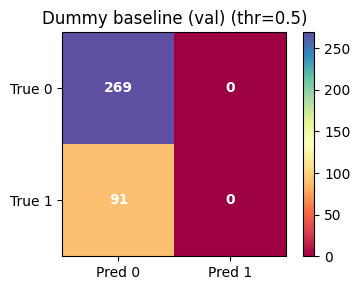

array([[269,   0],
       [ 91,   0]])

In [10]:
show_confusion(y_val, p_dummy_val, thr=0.5, title="Dummy baseline (val)")


---
## 6) LogReg + Pipeline: con vs sin escalado

La logística suele beneficiarse del escalado (cuando hay features en escalas muy distintas).


In [11]:
pipe_lr_scaled = Pipeline([
    ("preprocess", preprocess_scaled),
    ("model", LogisticRegression(max_iter=5000))
])

pipe_lr_noscale = Pipeline([
    ("preprocess", preprocess_noscale),
    ("model", LogisticRegression(max_iter=5000))
])

pipe_lr_scaled.fit(X_train, y_train)
pipe_lr_noscale.fit(X_train, y_train)

p_val_scaled = pipe_lr_scaled.predict_proba(X_val)[:, 1]
p_val_noscale = pipe_lr_noscale.predict_proba(X_val)[:, 1]

pd.DataFrame([
    clf_report(y_val, p_val_noscale),
    clf_report(y_val, p_val_scaled),
], index=["LogReg (NO scale)", "LogReg (WITH scale)"])


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
LogReg (NO scale),0.927778,0.891566,0.813187,0.850575,0.973365,0.944442
LogReg (WITH scale),0.927778,0.891566,0.813187,0.850575,0.973406,0.944584


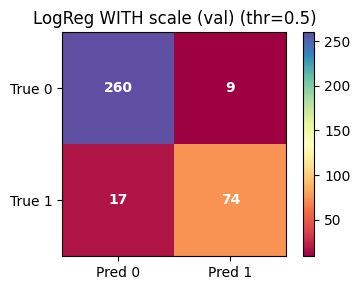

array([[260,   9],
       [ 17,  74]])

In [12]:

show_confusion(y_val, p_val_scaled, thr=0.5, title="LogReg WITH scale (val)")



---
## 7) Desbalance: `class_weight="balanced"` (visión general)

En muchos problemas reales la clase positiva es **rara** (fraude, enfermedad, deserción, incumplimiento, admisión a un programa selectivo). En esos casos, si entrenamos “normal”, el modelo puede preferir la clase mayoritaria porque así minimiza el error promedio, pero termina con **recall muy bajo** para la clase minoritaria.

Una estrategia simple (especialmente en modelos lineales como **Logistic Regression** o **SVM lineal**) es usar:

`class_weight="balanced"`

Esto significa **reponderar la función de pérdida** para que equivocarse en la clase minoritaria “cueste más”. En scikit-learn, los pesos se calculan automáticamente como:

$$
w_c=\frac{N}{K\cdot N_c}
$$

donde \(N\) es el número total de muestras, \(K\) el número de clases y \(N_c\) las muestras de la clase \(c\).  
Así, la clase rara recibe un peso mayor.

### ¿Qué efecto suele tener?
- Aumenta el **recall** de la clase minoritaria (detecta más positivos).
- Puede bajar la **precision** (aparecen más falsos positivos).
- En general cambia el “equilibrio” del clasificador sin tocar los datos.

### Ejemplos (tropicalizados)
- **Admisión**: pocos estudiantes son admitidos (1), muchos no (0). Queremos no dejar pasar a los admitibles → subir recall.
- **Fraude**: muy pocas transacciones son fraude (1). Preferimos detectar la mayoría de fraudes aunque investiguemos algunas falsas alarmas.
- **Salud**: pocos pacientes tienen la condición (1). Es costoso no detectarla → priorizar recall.

> Nota: `class_weight="balanced"` es una primera herramienta. Otras opciones incluyen **re-muestreo** (oversampling/undersampling), **ajustar el umbral**, o usar métricas objetivo como **PR-AUC**.


In [13]:
pipe_lr_bal = Pipeline([
    ("preprocess", preprocess_scaled),
    ("model", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

pipe_lr_bal.fit(X_train, y_train)
p_val_bal = pipe_lr_bal.predict_proba(X_val)[:, 1]

pd.DataFrame([
    clf_report(y_val, p_val_scaled),
    clf_report(y_val, p_val_bal),
], index=["LogReg (scale)", "LogReg (scale + balanced)"])

,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
LogReg (scale),0.927778,0.891566,0.813187,0.850575,0.973406,0.944584
LogReg (scale + balanced),0.911111,0.780952,0.901099,0.836735,0.973161,0.944165


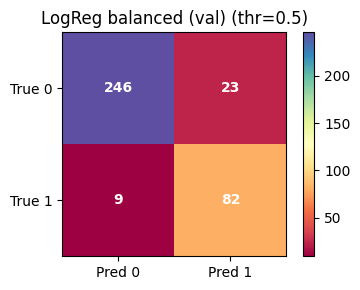

array([[246,  23],
       [  9,  82]])

In [14]:

show_confusion(y_val, p_val_bal, thr=0.5, title="LogReg balanced (val)")



---
## 8) Comparación de imputación: `mean` vs `median` (numéricas)


In [15]:
num_pipe_mean = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocess_mean = ColumnTransformer([
    ("num", num_pipe_mean, num_cols),
    ("cat", cat_pipe, cat_cols)
])

pipe_lr_mean = Pipeline([
    ("preprocess", preprocess_mean),
    ("model", LogisticRegression(max_iter=5000))
])

pipe_lr_mean.fit(X_train, y_train)
p_val_mean = pipe_lr_mean.predict_proba(X_val)[:, 1]

pd.DataFrame([
    clf_report(y_val, p_val_scaled),
    clf_report(y_val, p_val_mean),
], index=["Impute median", "Impute mean"])


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Impute median,0.927778,0.891566,0.813187,0.850575,0.973406,0.944584
Impute mean,0.927778,0.891566,0.813187,0.850575,0.977042,0.948851



---
## 9) Evaluación en TEST (una sola vez)

Congelamos unas configuraciones y evaluamos en test.


In [16]:

configs = {
    "Dummy": dummy,
    "LogReg_NOscale": pipe_lr_noscale,
    "LogReg_scale": pipe_lr_scaled,
    "LogReg_scale_balanced": pipe_lr_bal,
}

rows = []
for name, model in configs.items():
    p_test = model.predict_proba(X_test)[:, 1]
    rep = clf_report(y_test, p_test)
    rep["Model"] = name
    rows.append(rep)

pd.DataFrame(rows).set_index("Model").sort_values("PR_AUC", ascending=False)


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Model,,,,,,
LogReg_NOscale,0.927778,0.910256,0.788889,0.845238,0.959753,0.919623
LogReg_scale,0.930556,0.922078,0.788889,0.850299,0.959712,0.919546
LogReg_scale_balanced,0.900000,0.770000,0.855556,0.810526,0.959671,0.918958
Dummy,0.750000,0.000000,0.000000,0.000000,0.500000,0.250000


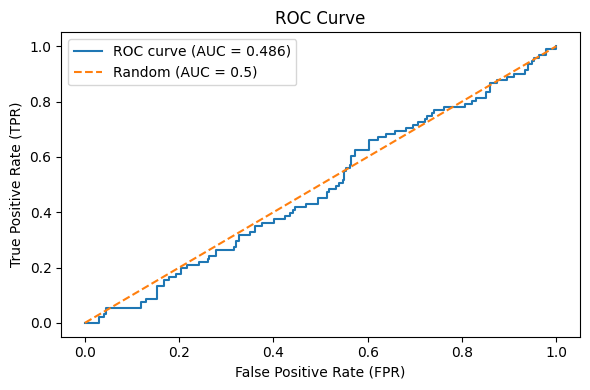

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# y_val (0/1) y p_val (probabilidades del modelo para la clase 1)
# Ejemplo: p_val = pipe_lr_scaled.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, p_test)
auc = roc_auc_score(y_val, p_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()



---
## 10) Ejercicios (Semana 2)

### Ejercicio 1 — Escalado (comparación)
Compara LogReg con y sin escalado en `val`. ¿Por qué cambia?

### Ejercicio 2 — Imputación
Cambia imputación numérica a `mean` y luego `median`. ¿Cuál esperas que sea más robusta ante outliers?

### Ejercicio 3 — Categóricas y categorías nuevas
Quita `handle_unknown="ignore"` y fuerza una categoría nueva en `X_test`. ¿Qué error sale? Explica.

### Ejercicio 4 — Desbalance
Compara LogReg normal vs `class_weight="balanced"`. ¿Qué trade-off observas entre precision y recall?

### Ejercicio 5 — Umbral
Con el modelo balanceado, evalúa umbrales 0.2, 0.5, 0.8 en `val`. ¿Cuál escogerías si falsos negativos son muy costosos?
